In [1]:
import glob
import json
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
from collections import defaultdict

from scipy.spatial.distance import euclidean
import cv2
import time
from fastdtw import fastdtw

# machine learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
capacitance_data = {}

with open('recording_id222_rightHanded.json') as file:
    for i, line in enumerate(file):
        json_string = line.rstrip()
        try:
            obj = json.loads(json_string)
        except:
            break
        capacitance_data.update(obj)

## Preprocessing

In [3]:
flat_cap_data = [k.split(".")[:-1] + [v[0]] for k, v in pd.json_normalize(capacitance_data).to_dict().items()]
flat_cap_data = [w1 + [w2[-1]] for w1, w2 in zip(flat_cap_data[::2], flat_cap_data[1::2])]
flat_cap_data = sorted(flat_cap_data, key=lambda w: w[1])

In [4]:
def preprocess(img):
    img[img < 0] = 0

    new_cap_img = [0] * 49 * 37
    new_cap_img_cst = [0] * 49 * 37
    for y in range(49):
        for x in range(37):
            val = img[y * 37 + x]
            new_cap_img[(37 - x - 1) * 49 + y] = val
            new_cap_img_cst[(37 - x - 1) * 49 + y] = 100 if val>5 else 0
    cap_img_2d = np.reshape(new_cap_img, (37, 49))
    cap_img_2d_cst = np.reshape(new_cap_img_cst, (37, 49))

    nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(np.array(cap_img_2d_cst, dtype=np.uint8))
    sizes = stats[:, -1]
    sizes = sizes[1:]
    nb_blobs -= 1
    min_size = 60

    for blob in range(nb_blobs):
        if sizes[blob] < min_size:
            cap_img_2d[im_with_separated_blobs == blob + 1] = 0

    return cap_img_2d

In [5]:
def preprocess_cap_data(imgs):
    prep_flat_cap_data = imgs.copy()
    for pfcp in prep_flat_cap_data:
        pfcp[-1] = np.array(pfcp[-1])
        pfcp[-1] = preprocess(pfcp[-1])
    prep_flat_cap_data = [pfcp for pfcp in prep_flat_cap_data if pfcp[-1].sum() > 1000]
    return prep_flat_cap_data

In [6]:
prep_flat_cap_data = preprocess_cap_data(flat_cap_data)

In [7]:
df = pd.DataFrame (prep_flat_cap_data, columns = ['digit', 'timestamp', 'pen_pos', 'cap_img'])
df

,digit,timestamp,pen_pos,cap_img
0,7lf0,1551101426496,"[21, 21]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,7lf0,1551101426578,"[21, 21]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,7lf0,1551101426645,"[21, 21]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,7lf0,1551101426717,"[21, 21]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,7lf0,1551101426788,"[21, 21]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...
8296,2lg0,1551102709220,"[792, 1053]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 10..."
8297,2lg0,1551102709296,"[838, 1054]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 28..."
8298,2lg0,1551102709372,"[879, 1051]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 14, 4..."
8299,2lg0,1551102709447,"[895, 1054]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 5..."


In [8]:
def compute_img(cap_img):
    new_cap_img = [0] * 49 * 37
    for y in range(49):
        for x in range(37):
            val = cap_img[y * 37 + x]
            new_cap_img[(37 - x - 1) * 49 + y] = val
    cap_img_2d = np.reshape(new_cap_img, (37, 49))
    return cap_img_2d

In [9]:
df["cap_img_2d"]=df["cap_img"]

## Feature generation

### Centers of mass

In [10]:
df["com"] = df["cap_img_2d"].apply(ndimage.center_of_mass)

In [11]:
df_coms = df.groupby("digit").aggregate(lambda x: list(x))[["pen_pos", "com", "cap_img_2d"]].reset_index()

In [12]:
# remove subsequent equal centers of mass
def filter_consec(coms):
    return [c[0] for c in zip(coms, coms[1:]+[[1000,1000]]) if c[0]!=c[1]]

In [13]:
df_coms["com"] = df_coms["com"].apply(filter_consec)

In [14]:
def get_2d_coms(coms):
    coms_2d = [0] * 49 * 37
    coms_2d = np.reshape(coms_2d, (37, 49))
    coms_bin = set([(int(com[0]),int(com[1]) )for com in coms])
    for com in coms_bin:
        coms_2d[com[0]][com[1]]=1
    return coms_2d

In [15]:
df_coms.cap_img_2d.apply(len).describe()

count    300.00000
mean      27.67000
std        6.80604
min       14.00000
25%       23.00000
50%       27.00000
75%       32.00000
max       52.00000
Name: cap_img_2d, dtype: float64

In [16]:
df_coms["2d_coms"] = df_coms["com"].apply(get_2d_coms)
df_coms

,digit,pen_pos,com,cap_img_2d,2d_coms
0,0lf0,"[[766, 748], [766, 748], [682, 469], [653, 454...","[(14.032749602001365, 18.192631339549692), (13...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0lf1,"[[573, 853], [573, 853], [573, 853], [617, 467...","[(13.694470188446092, 19.21933889403769), (14....","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,0lf2,"[[471, 874], [471, 874], [579, 467], [553, 489...","[(15.09253287025552, 19.740014884644008), (15....","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,0lf3,"[[699, 608], [699, 608], [699, 608], [581, 457...","[(12.786771105308965, 19.92167101827676), (13....","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0lf4,"[[779, 781], [779, 781], [636, 451], [609, 452...","[(13.477648933345137, 18.533947065592635), (13...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
295,9sg0,"[[940, 1042], [940, 1042], [940, 1042], [666, ...","[(9.656752411575562, 19.790996784565916), (9.7...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
296,9sg1,"[[661, 593], [661, 593], [661, 593], [661, 593...","[(10.758440845457041, 18.318144386494648), (10...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
297,9sg2,"[[646, 846], [646, 846], [646, 846], [646, 846...","[(9.174729241877257, 19.47725631768953), (9.98...","[[[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
298,9sg3,"[[706, 1085], [706, 1085], [706, 1085], [706, ...","[(11.623104763767975, 17.575173628093516), (11...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [17]:
len(df_coms.cap_img_2d[0])

29

In [18]:
df_coms.com[0]

[(14.032749602001365, 18.192631339549692),
 (13.585130793942175, 19.436110928997575),
 (13.235055417600387, 20.058930410029678),
 (13.09315165041701, 20.383061200516856),
 (12.974093264248705, 20.835964644925326),
 (12.172563625077592, 21.31731843575419),
 (11.383423753186483, 21.5282044578077),
 (10.364491038214407, 21.69218802840717),
 (9.383196281730426, 21.606292456203075),
 (7.884269245072518, 21.27296392711045),
 (6.921749316673175, 20.5443186255369),
 (6.2975887247410425, 19.497962302598065),
 (6.019020979020979, 18.246247086247088),
 (6.118600330305533, 17.089801816680428),
 (6.164042131609135, 16.314109917613933),
 (6.546790162887256, 15.721388267859044),
 (6.800766283524904, 15.383567475521499),
 (7.483075435203094, 15.004593810444874),
 (8.387437544610993, 14.756745182012848),
 (9.694277340737314, 14.929970692580595),
 (10.87555775904809, 15.12609486035366),
 (12.188450272004463, 15.334495745571209),
 (13.85014679976512, 15.742924251321197),
 (14.331270627062706, 16.46606848

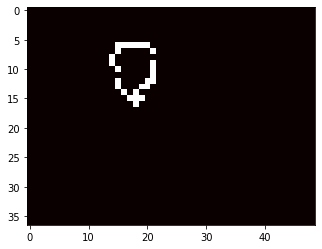

In [19]:
plt.imshow(df_coms["2d_coms"][0], cmap='hot', interpolation='nearest')
plt.show()

TypeError: Invalid shape (49,) for image data

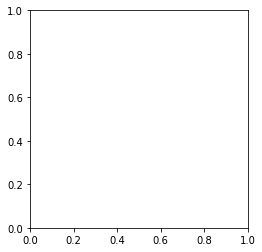

In [20]:
for ci in df_coms["2d_coms"][0]:
    plt.imshow(ci, cmap='hot', interpolation='nearest')
    plt.show()

In [22]:
def get_bounded_2d_coms(coms_2d):
    #up/down bounds
    i=0
    while(sum(coms_2d[i])==0):
        i+=1
    j=-1
    while(sum(coms_2d[j])==0):
        j-=1
    #right/left bounds
    l=0
    while(sum(coms_2d[:,l])==0):
        l+=1
    r=-1
    while(sum(coms_2d[:,r])==0):
        r-=1
    return [row[l:r+1] for row in coms_2d[i:j+1]]

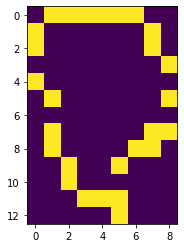

In [23]:
for i in range(10):
    # print(df_coms["digit"][i])
    plt.imshow(get_bounded_2d_coms(df_coms["2d_coms"][i]))

### Deltas

In [24]:
def get_deltas(coms):
    coms_np = np.array(coms)
    deltas = coms_np[:-1] - coms_np[1:]
    row_sums = np.linalg.norm(deltas, axis=1, keepdims=True)
    normalized_deltas = deltas / row_sums
    return normalized_deltas

In [25]:
df_coms["deltas"] = df_coms["com"].apply(get_deltas)
df_coms

,digit,pen_pos,com,cap_img_2d,2d_coms,deltas
0,0lf0,"[[766, 748], [766, 748], [682, 469], [653, 454...","[(14.032749602001365, 18.192631339549692), (13...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.338696797648796, -0.9408955729848294], [0...."
1,0lf1,"[[573, 853], [573, 853], [573, 853], [617, 467...","[(13.694470188446092, 19.21933889403769), (14....","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.9977562387641863, 0.0669513854012295], [0..."
2,0lf2,"[[471, 874], [471, 874], [579, 467], [553, 489...","[(15.09253287025552, 19.740014884644008), (15....","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.18112385273622061, -0.9834602940485131], ..."
3,0lf3,"[[699, 608], [699, 608], [699, 608], [581, 457...","[(12.786771105308965, 19.92167101827676), (13....","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.9977307375500312, -0.06733034492612257], ..."
4,0lf4,"[[779, 781], [779, 781], [636, 451], [609, 452...","[(13.477648933345137, 18.533947065592635), (13...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.6300545478186649, -0.7765508784188049], [..."
...,...,...,...,...,...,...
295,9sg0,"[[940, 1042], [940, 1042], [940, 1042], [666, ...","[(9.656752411575562, 19.790996784565916), (9.7...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.5577041421130676, 0.830039812219828], [0...."
296,9sg1,"[[661, 593], [661, 593], [661, 593], [661, 593...","[(10.758440845457041, 18.318144386494648), (10...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.37917230696509596, -0.9253260839459606], ..."
297,9sg2,"[[646, 846], [646, 846], [646, 846], [646, 846...","[(9.174729241877257, 19.47725631768953), (9.98...","[[[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.9972822235195234, -0.07367609281140833], ..."
298,9sg3,"[[706, 1085], [706, 1085], [706, 1085], [706, ...","[(11.623104763767975, 17.575173628093516), (11...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.8986476937788577, -0.438671086881664], [0...."


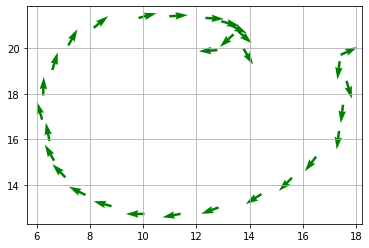

<Figure size 432x288 with 0 Axes>

In [26]:
x = [c[0] for c in df_coms["com"][3][:-1]]
y = [c[1] for c in df_coms["com"][3][:-1]]

u = [d[0] for d in df_coms["deltas"][3]]
v = [d[1] for d in df_coms["deltas"][3]]

plt.quiver(x, y, u, v, color='g')

plt.grid()
plt.show()
plt.savefig("kw.png")

In [27]:
df_coms["digit"][3]

'0lf3'

In [28]:
# get the angles between the deltas and the horizontal axis
def get_delta_angles(deltas):
    return [np.arccos(np.clip(np.dot(d, [1,0]), -1.0, 1.0)) for d in deltas]

In [29]:
df_coms["delta_angles"] = df_coms["deltas"].apply(get_delta_angles)

### Optical flow

In [30]:
lk_params = dict(winSize  = (15, 15),
                maxLevel = 2,
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict(maxCorners = 20,
                    qualityLevel = 0.3,
                    minDistance = 10,
                    blockSize = 7 )


detect_interval = 5

def get_trajectories(cap_imgs):
    trajectories = []
    frame_idx = 0

    for frame in cap_imgs:
        # frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_gray = np.array(frame, dtype=np.uint8)

        # Calculate optical flow for a sparse feature set using the iterative Lucas-Kanade Method
        if len(trajectories) > 0:
            img0, img1 = prev_gray, frame_gray
            p0 = np.float32([trajectory[-1] for trajectory in trajectories]).reshape(-1, 1, 2)
            p1, _st, _err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
            p0r, _st, _err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
            d = abs(p0-p0r).reshape(-1, 2).max(-1)
            good = d < 100

            new_trajectories = []

            # Get all the trajectories
            for trajectory, (x, y), good_flag in zip(trajectories, p1.reshape(-1, 2), good):
                if not good_flag:
                    continue
                trajectory.append((x, y))
                new_trajectories.append(trajectory)

            trajectories = new_trajectories


        # Update interval - When to update and detect new features
        if frame_idx % detect_interval == 0:
            mask = np.zeros_like(frame_gray)
            mask[:] = 255

            # Lastest point in latest trajectory
            for x, y in [np.int32(trajectory[-1]) for trajectory in trajectories]:
                cv2.circle(mask, (x, y), 5, 0, -1)

            # Detect the good features to track
            p = cv2.goodFeaturesToTrack(frame_gray, mask = mask, **feature_params)
            if p is not None:
                # If good features can be tracked - add that to the trajectories
                for x, y in np.float32(p).reshape(-1, 2):
                    trajectories.append([(x, y)])


        frame_idx += 1
        prev_gray = frame_gray

    tr = [get_deltas(list(set(t))) for t in trajectories if len(set(t))>6]
    return tr

In [31]:
df_coms["trajectories"] = df_coms["cap_img_2d"].apply(get_trajectories)

## Prediction

In [32]:
def dtw(s, t, window):
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)])
    dtw_matrix = np.zeros((n+1, m+1))

    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0

    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [33]:
import scipy.spatial as sp
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp


In [34]:
def compute_2d_coms_sim(coms1, coms2):
    return sam(coms1, coms2)

In [35]:
def compute_deltas_sim(deltas1, deltas2):
    # return 1./dtw(deltas1,deltas2, 3)[-1][-1]
    return 1./max(fastdtw(deltas1, deltas2, dist=euclidean)[0],5)

In [36]:
def compute_traj_sim(trajs1, trajs2):
    res=[[0]*len(trajs2)]*len(trajs1)
    for i in range(len(trajs1)):
        for j in range(len(trajs2)):
            res[i][j] = fastdtw(trajs1[i], trajs2[j], dist=euclidean)[0]
    return 1./np.mean([min(d) for d in res])

In [37]:
# data=dict(zip(df_coms.digit, zip(df_coms["2d_coms"], df_coms.delta_angles)))
data=dict(zip(df_coms.digit, zip(df_coms["2d_coms"], df_coms.deltas, df_coms.trajectories)))

In [38]:
data2 = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
for d in data:
    data2[d[1]][d[2]][int(d[0])].append(data[d])

### Using digit of same size and style as reference

In [39]:
accuracies = defaultdict(dict)
for size in ["l","m","s"]:
    print(size)
    for style in ["f","g"]:
        preds_delta=[]
        preds_coms=[]
        preds_traj=[]
        for digit_pred in range(10):
            for which_ref in range(5):
                for which in (w for w in range(5) if w != which_ref):
                    best_sim_delta=-1
                    digit_best_sim_delta=-1
                    best_sim_coms=-1
                    digit_best_sim_coms=-1
                    best_sim_traj=-1
                    digit_best_sim_traj=-1
                    for digit_ref in range(10):
                        coms_sim = compute_2d_coms_sim(data2[size][style][digit_ref][which_ref][0], data2[size][style][digit_pred][which][0])
                        deltas_sim = compute_deltas_sim(data2[size][style][digit_ref][which_ref][1], data2[size][style][digit_pred][which][1])
                        traj_sim = compute_traj_sim(data2[size][style][digit_ref][which_ref][2], data2[size][style][digit_pred][which][2])
                        if coms_sim>best_sim_coms:
                            best_sim_coms=coms_sim
                            digit_best_sim_coms=digit_ref
                        if deltas_sim>best_sim_delta:
                            best_sim_delta=deltas_sim
                            digit_best_sim_delta=digit_ref
                        if traj_sim>best_sim_traj:
                            best_sim_traj=traj_sim
                            digit_best_sim_traj=digit_ref
                    if digit_best_sim_delta==digit_pred:
                        preds_delta.append(1)
                    else:
                        # print(f"{digit_pred} was wrongly classified as {digit_best_sim_delta}")
                        preds_delta.append(0)
                    if digit_best_sim_coms==digit_pred:
                        preds_coms.append(1)
                    else:
                        preds_coms.append(0)
                    if digit_best_sim_traj==digit_pred:
                        preds_traj.append(1)
                    else:
                        preds_traj.append(0)
        acc=(np.array(preds_coms).mean(),np.array(preds_delta).mean(),np.array(preds_traj).mean())
        accuracies[size][style]=acc

l
m
s


In [59]:
np.array([0.025, 0.05,0.05,0.025,0.025]).std()

0.012247448713915891

In [52]:
for size in ["l","m","s"]:
    for style in ["f","g"]:
        print(f'Accuracy for {"medium" if size=="m" else "small" if size=="s" else "large"} size and {"freehand" if style=="f" else "guided"} writing with centers of mass prediction: {accuracies[size][style][0]}')
        print(f'Accuracy for {"medium" if size=="m" else "small" if size=="s" else "large"} size and {"freehand" if style=="f" else "guided"} writing with deltas prediction: {accuracies[size][style][1]}')
        print(f'Accuracy for {"medium" if size=="m" else "small" if size=="s" else "large"} size and {"freehand" if style=="f" else "guided"} writing with optical flow prediction: {accuracies[size][style][2]}')

Accuracy for large size and freehand writing with centers of mass prediction: 0.035
Accuracy for large size and freehand writing with deltas prediction: 0.955
Accuracy for large size and freehand writing with optical flow prediction: 0.2
Accuracy for large size and guided writing with centers of mass prediction: 0.06
Accuracy for large size and guided writing with deltas prediction: 0.935
Accuracy for large size and guided writing with optical flow prediction: 0.27
Accuracy for medium size and freehand writing with centers of mass prediction: 0.11
Accuracy for medium size and freehand writing with deltas prediction: 0.72
Accuracy for medium size and freehand writing with optical flow prediction: 0.17
Accuracy for medium size and guided writing with centers of mass prediction: 0.11
Accuracy for medium size and guided writing with deltas prediction: 0.865
Accuracy for medium size and guided writing with optical flow prediction: 0.195
Accuracy for small size and freehand writing with cent

In [53]:
for size in ["l","m","s"]:
    print(f'Accuracy for {"medium" if size=="m" else "small" if size=="s" else "large"} digits: {np.mean(accuracies[size]["f"]+accuracies[size]["g"]):.3f}')

Accuracy for large digits: 0.409
Accuracy for medium digits: 0.362
Accuracy for small digits: 0.258


In [54]:
#DTW
for size in ["l","m","s"]:
    print(f'Accuracy for {"medium" if size=="m" else "small" if size=="s" else "large"} digits: {(accuracies[size]["f"][1]+accuracies[size]["g"][1])/2.0:.3f}')

Accuracy for large digits: 0.945
Accuracy for medium digits: 0.792
Accuracy for small digits: 0.560


In [55]:
for style in ["f","g"]:
    print(f'Accuracy for {"freehand" if style=="f" else "guided"} digits: {np.mean(accuracies["l"][style]+accuracies["m"][style]+accuracies["s"][style]):.3f}')

Accuracy for freehand digits: 0.332
Accuracy for guided digits: 0.353


In [56]:
#DTW
for style in ["f","g"]:
    print(f'Accuracy for {"freehand" if style=="f" else "guided"} digits: {(accuracies["l"][style][1]+accuracies["m"][style][1]+accuracies["s"][style][1])/3.0:.3f}')

Accuracy for freehand digits: 0.765
Accuracy for guided digits: 0.767


In [61]:
com_accs=[]
delta_accs=[]
optic_accs=[]
for size in ["l","m","s"]:
    for style in ["f","g"]:
        com, delta, optic = accuracies[size][style]
        com_accs.append(com)
        delta_accs.append(delta)
        optic_accs.append(optic)
print(f"Accuracy for centers of mass method: {np.mean(com_accs):.3f}, {np.std(com_accs):.3f}")
print(f"Accuracy for deltas method: {np.mean(delta_accs):.3f}, {np.std(delta_accs):.3f}")
print(f"Accuracy for optical flow method: {np.mean(optic_accs):.3f}, {np.std(optic_accs):.3f}")


Accuracy for centers of mass method: 0.079, 0.029
Accuracy for deltas method: 0.766, 0.167
Accuracy for optical flow method: 0.183, 0.048


### Using large guided digit as reference

In [48]:
preds_delta=[]
preds_coms=[]
preds_traj=[]
for size in ["l","m","s"]:
    print(size)
    for style in ["f","g"]:
        for digit_pred in range(10):
            for which in range(1,5):
                best_sim_delta=-1
                digit_best_sim_delta=-1
                best_sim_coms=-1
                digit_best_sim_coms=-1
                best_sim_traj=-1
                digit_best_sim_traj=-1
                for digit_ref in range(10):
                    coms_sim = compute_2d_coms_sim(data2["l"]["g"][digit_ref][0][0], data2[size][style][digit_pred][which][0])
                    deltas_sim = compute_deltas_sim(data2["l"]["g"][digit_ref][0][1], data2[size][style][digit_pred][which][1])
                    traj_sim = compute_traj_sim(data2["l"]["g"][digit_ref][0][2], data2[size][style][digit_pred][which][2])
                    if coms_sim>best_sim_coms:
                        best_sim_coms=coms_sim
                        digit_best_sim_coms=digit_ref
                    if deltas_sim>best_sim_delta:
                        best_sim_delta=deltas_sim
                        digit_best_sim_delta=digit_ref
                    if traj_sim>best_sim_traj:
                        best_sim_traj=traj_sim
                        digit_best_sim_traj=digit_ref
                if digit_best_sim_delta==digit_pred:
                    preds_delta.append(1)
                else:
                    preds_delta.append(0)
                if digit_best_sim_coms==digit_pred:
                    preds_coms.append(1)
                else:
                    preds_coms.append(0)
                if digit_best_sim_traj==digit_pred:
                    preds_traj.append(1)
                else:
                    preds_traj.append(0)
acc=(np.array(preds_coms).mean(),np.array(preds_delta).mean(),np.array(preds_traj).mean())

l
m
s


In [50]:
print(f"Accuracy for centers of mass method: {acc[0]:.3f}")
print(f"Accuracy for deltas method: {acc[1]:.3f}")
print(f"Accuracy for optical flow method: {acc[2]:.3f}")

Accuracy for centers of mass method: 0.083
Accuracy for deltas method: 0.654
Accuracy for optical flow method: 0.163


### Plot evolution of accuracy depending on how many digits are being predicted

In [63]:
accs=[]
for num_digits in range(2,11):
    print(num_digits)
    preds_delta=[]
    preds_coms=[]
    preds_traj=[]
    for size in ["l","m","s"]:
        for style in ["f","g"]:
            for digit_pred in range(num_digits):
                for which in range(1,5):
                    best_sim_delta=-1
                    digit_best_sim_delta=-1
                    best_sim_coms=-1
                    digit_best_sim_coms=-1
                    best_sim_traj=-1
                    digit_best_sim_traj=-1
                    for digit_ref in range(num_digits):
                        coms_sim = compute_2d_coms_sim(data2["l"]["g"][digit_ref][0][0], data2[size][style][digit_pred][which][0])
                        deltas_sim = compute_deltas_sim(data2["l"]["g"][digit_ref][0][1], data2[size][style][digit_pred][which][1])
                        traj_sim = compute_traj_sim(data2["l"]["g"][digit_ref][0][2], data2[size][style][digit_pred][which][2])
                        if coms_sim>best_sim_coms:
                            best_sim_coms=coms_sim
                            digit_best_sim_coms=digit_ref
                        if deltas_sim>best_sim_delta:
                            best_sim_delta=deltas_sim
                            digit_best_sim_delta=digit_ref
                        if traj_sim>best_sim_traj:
                            best_sim_traj=traj_sim
                            digit_best_sim_traj=digit_ref
                    if digit_best_sim_delta==digit_pred:
                        preds_delta.append(1)
                    else:
                        preds_delta.append(0)
                    if digit_best_sim_coms==digit_pred:
                        preds_coms.append(1)
                    else:
                        preds_coms.append(0)
                    if digit_best_sim_traj==digit_pred:
                        preds_traj.append(1)
                    else:
                        preds_traj.append(0)
    acc=(np.array(preds_coms).mean(),np.array(preds_delta).mean(),np.array(preds_traj).mean())
    accs.append(acc)

2
3
4
5
6
7
8
9
10


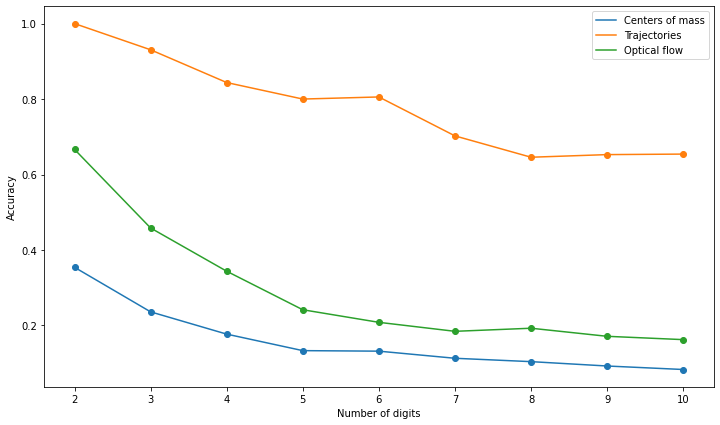

In [64]:
plt.figure(figsize=(12, 7))
labels=["Centers of mass","Trajectories","Optical flow"]
for i in range(3):
    plt.scatter(np.arange(2,11), [a[i] for a in accs])
    plt.plot(np.arange(2,11), [a[i] for a in accs], label=labels[i])
plt.xlabel("Number of digits")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
#take one example of optical flow trajectories and show why it doesnt work
# cross subject analysis

### Similarity heatmap

In [40]:
sims = [[0 for _ in range(len(df_coms))] for _ in range(len(df_coms))]
for i in range(len(df_coms)):
    for j in range(len(df_coms)):
        sims[i][j] = compute_deltas_sim(df_coms["deltas"][i], df_coms["deltas"][j])

In [41]:
pd.DataFrame(data=sims, columns=df_coms["digit"],index=df_coms["digit"])

digit,0lf0,0lf1,0lf2,0lf3,0lf4,0lg0,0lg1,0lg2,0lg3,0lg4,...,9sf0,9sf1,9sf2,9sf3,9sf4,9sg0,9sg1,9sg2,9sg3,9sg4
digit,,,,,,,,,,,,,,,,,,,,,
0lf0,0.200000,0.158869,0.166615,0.141035,0.146783,0.118395,0.131112,0.152986,0.151859,0.184429,...,0.046723,0.041893,0.064863,0.051495,0.053547,0.036216,0.056779,0.039373,0.044838,0.049825
0lf1,0.158869,0.200000,0.175550,0.200000,0.174945,0.162809,0.146714,0.151657,0.140246,0.119553,...,0.052304,0.038107,0.056993,0.045724,0.045689,0.040581,0.050835,0.042621,0.038580,0.032547
0lf2,0.166615,0.175550,0.200000,0.146360,0.172913,0.128905,0.134365,0.112477,0.123607,0.112967,...,0.044216,0.037860,0.051738,0.045826,0.046797,0.038253,0.056686,0.040343,0.036402,0.045697
0lf3,0.141035,0.200000,0.146360,0.200000,0.173996,0.140535,0.125580,0.159252,0.154639,0.130621,...,0.047584,0.038092,0.050477,0.044468,0.042014,0.038834,0.045692,0.042494,0.034365,0.045120
0lf4,0.146783,0.174945,0.172913,0.173996,0.200000,0.154287,0.134623,0.158627,0.125054,0.145019,...,0.053732,0.040750,0.055162,0.048599,0.050928,0.036774,0.053666,0.041068,0.037811,0.047450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9sg0,0.036216,0.040581,0.038253,0.038834,0.036774,0.037982,0.029014,0.034112,0.034507,0.037337,...,0.055015,0.047926,0.060265,0.047681,0.047921,0.200000,0.053220,0.055221,0.047086,0.065662
9sg1,0.056779,0.050835,0.056686,0.045692,0.053666,0.044022,0.045188,0.046897,0.045629,0.051719,...,0.050575,0.067079,0.078337,0.059839,0.051764,0.053220,0.200000,0.082564,0.065286,0.073144
9sg2,0.039373,0.042621,0.040343,0.042494,0.041068,0.035060,0.032896,0.035893,0.039831,0.037200,...,0.062066,0.066028,0.061492,0.058056,0.052863,0.055221,0.082564,0.200000,0.056372,0.060143


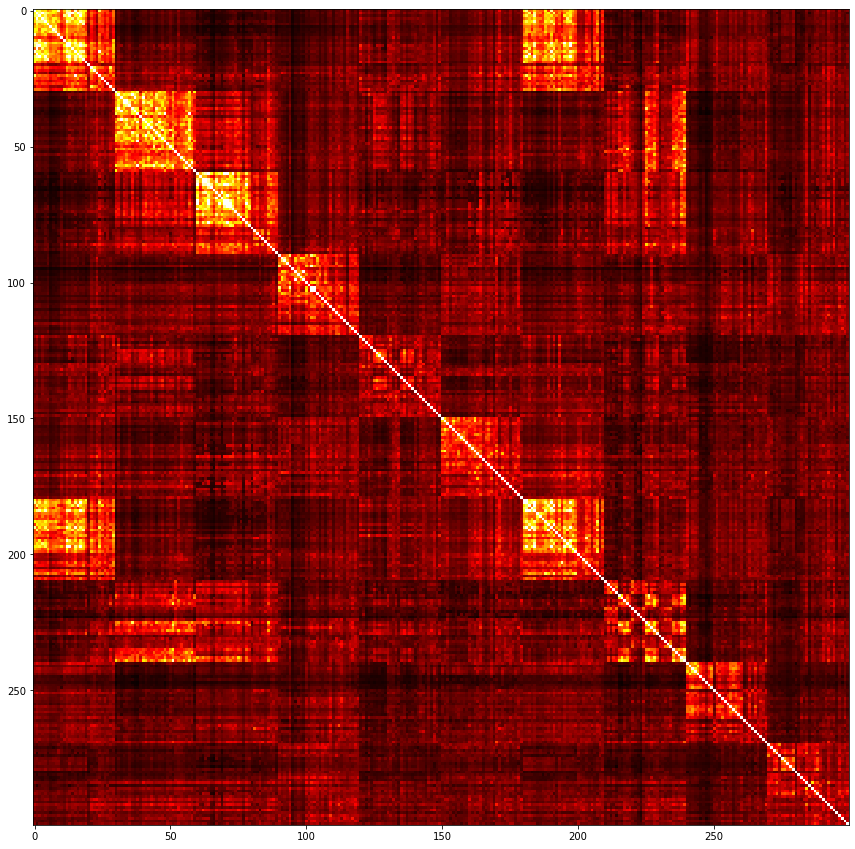

<Figure size 432x288 with 0 Axes>

In [42]:
plt.figure(figsize=(15, 15))

plt.imshow(sims, cmap='hot', interpolation='nearest')
plt.show()
plt.savefig("vvv.png", dpi=500  )